In [ ]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
from core.evaluation import MLEvaluator
from core.reconstruction import MLReconstructorBase
import core
import keras


PLOTS_DIR = "plots/plot_HLF_comp_histories/"
CONFIG_PATH = "../config/workspace_config_HLF.yaml"
CONFIG_PATH_BASELINE = "../config/workspace_config.yaml"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH_BASELINE)
load_config_high_level = get_load_config_from_yaml(
    CONFIG_PATH
)
DataProcessor = DataPreprocessor(load_config)
DataProcessor_high_level = DataPreprocessor(load_config_high_level)

with open(CONFIG_PATH_BASELINE, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz(
    data_configs["data_path"]["nominal"], max_events=400_000
)
X_val, y_val = DataProcessor.get_data()
data_config_high_level = DataProcessor_high_level.load_from_npz(
    data_configs["data_path"]["nominal"], max_events=400_000
)
X_val_high_level, y_val_high_level = DataProcessor_high_level.get_data()
MODEL_DIRS = ["../models/CrossAttentionTransformer_d256_l10_h8/", "../models/FeatureConcatTransformer_d256_l10_h8/", "../models/FeatureConcatTransformer_d256_l10_h8_HLF/"]
MODEL_CONFIGS = [data_config, data_config, data_config_high_level]
MODEL_NAMES = ["CrossAttention", "Transformer", "Transformer High Level Features"]
MODEL_X_TEST = [X_val, X_val, X_val_high_level]
MODEL_Y_TEST = [y_val, y_val, y_val_high_level]

ml_reconstructors = []
ml_evaluators = []
for i in range(len(MODEL_DIRS)):
    reconstructor = MLReconstructorBase(MODEL_CONFIGS[i], name=MODEL_NAMES[i], perform_regression=False)
    reconstructor.load_model(MODEL_DIRS[i] + "model.keras")
    ml_reconstructors.append(reconstructor)

evaluator = MLEvaluator(
    reconstructor=ml_reconstructors,
    X_test=MODEL_X_TEST,
    y_test=MODEL_Y_TEST,
)
plt.rcParams.update({"font.size": 14})


2025-11-29 19:06:35.381665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764439595.404372  560487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764439595.411968  560487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764439595.429847  560487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764439595.429867  560487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764439595.429870  560487 computation_placer.cc:177] computation placer alr

Model loaded from models/assignment_rnn/model.keras
Training history loaded from models/assignment_rnn/model_history.npz
Model loaded from models/assignment_transformer/model.keras
Training history loaded from models/assignment_transformer/model_history.npz
Model loaded from models/assignment_transformer_HLF/model.keras
Training history loaded from models/assignment_transformer_HLF/model_history.npz


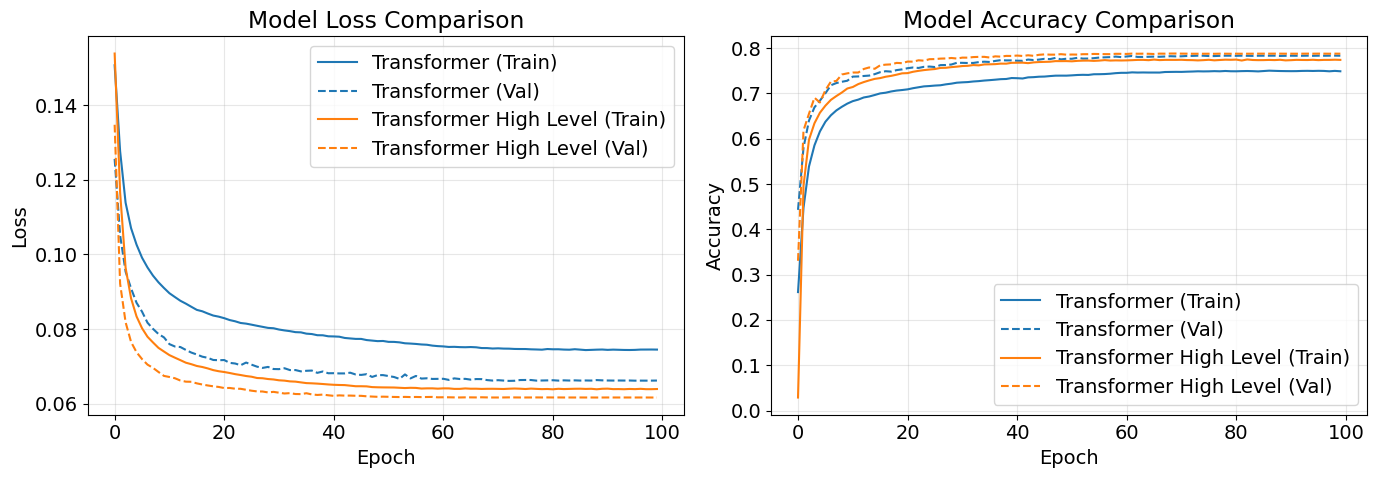

In [2]:
fig, ax = evaluator.plot_training_history()
fig.savefig(PLOTS_DIR + "training_histories_comparison.png")

Renaming features:
  lep_pt -> $p_{T}(\ell)$
  lep_eta -> $\eta(\ell)$
  lep_phi -> $\phi(\ell)$
  lep_e -> $E(\ell)$
  ordered_jet_pt -> $p_{T}(\text{jet})$
  ordered_jet_eta -> $\eta(\text{jet})$
  ordered_jet_phi -> $\phi(\text{jet})$
  ordered_jet_e -> $E(\text{jet})$
  ordered_jet_b_tag -> b-tag
  met_met -> $p_{T}(miss)$
  met_phi -> $\phi(miss)$
  N_jets -> N_jets
  dR_l1l2 -> dR_l1l2
  truth_ttbar_mass -> truth_ttbar_mass
  truth_ttbar_pt -> truth_ttbar_pt
  truth_top_mass -> truth_top_mass
  truth_tbar_mass -> truth_tbar_mass
  truth_initial_parton_num_gluons -> truth_initial_parton_num_gluons
  weight -> weight
  truth_top_neutrino_px -> truth_top_neutrino_px
  truth_top_neutrino_py -> truth_top_neutrino_py
  truth_top_neutrino_pz -> truth_top_neutrino_pz
  nu_flows_neutrino_px -> nu_flows_neutrino_px
  nu_flows_neutrino_py -> nu_flows_neutrino_py
  nu_flows_neutrino_pz -> nu_flows_neutrino_pz
  truth_top_pt -> truth_top_pt
  truth_top_eta -> truth_top_eta
  truth_top_phi -> 

I0000 00:00:1764439738.195817  563153 service.cc:152] XLA service 0x556a3e6e71c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764439738.195845  563153 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-29 19:08:58.250098: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-29 19:08:58.276779: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764439738.551375  563153 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1764439739.480199  563153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-29 19:09:07.856388: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring

Baseline Assignment Performance: 0.7949
Saved feature importance plot to plots/plot_HLF_comp_histories//Transformer_feature_importance.png
Computing feature importance for Transformer High Level (features: jet, lepton, met)...


2025-11-29 19:11:44.718772: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-29 19:11:54.631050: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


Baseline Assignment Performance: 0.7993
Saved feature importance plot to plots/plot_HLF_comp_histories//Transformer High Level_feature_importance.png


[(<Figure size 600x600 with 1 Axes>,
  <Axes: title={'center': 'Feature Importance - Transformer'}, xlabel='Importance Score'>),
 (<Figure size 600x600 with 1 Axes>,
  <Axes: title={'center': 'Feature Importance - Transformer High Level'}, xlabel='Importance Score'>)]

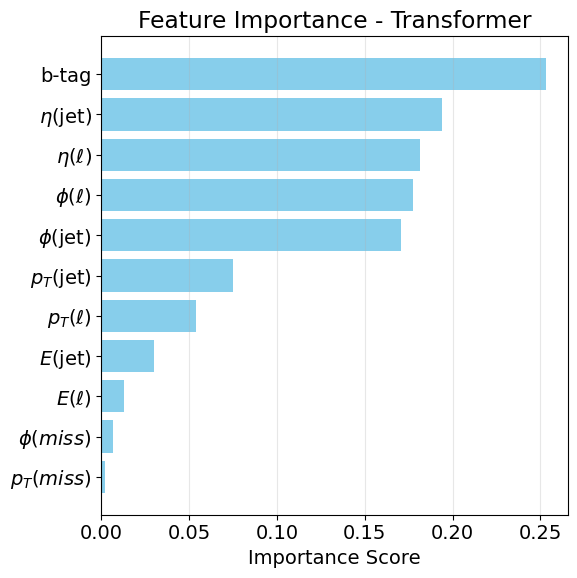

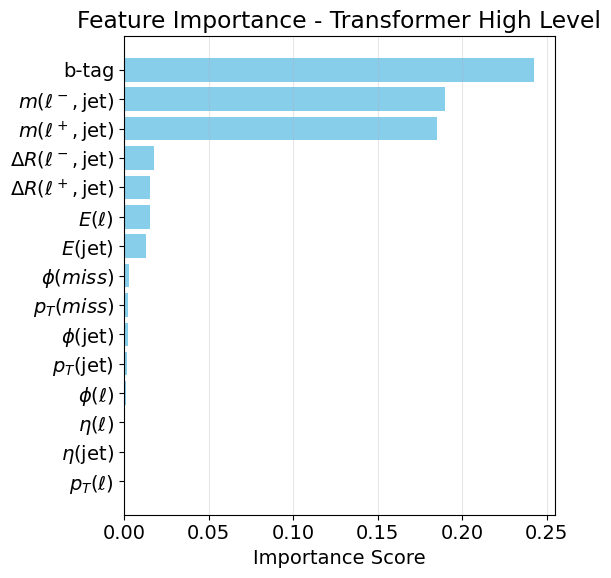

In [3]:
def rename_features(str):
    if str == "ordered_jet_b_tag":
        return "b-tag"
    elif str == "ordered_jet_pt":
        return r"$p_{T}(\text{jet})$"
    elif str == "ordered_jet_eta":
        return r"$\eta(\text{jet})$"
    elif str == "ordered_jet_phi":
        return r"$\phi(\text{jet})$"
    elif str == "ordered_jet_e":
        return r"$E(\text{jet})$"
    elif str == "lep_pt":
        return r"$p_{T}(\ell)$"
    elif str == "lep_eta":
        return r"$\eta(\ell)$"
    elif str == "lep_phi":
        return r"$\phi(\ell)$"
    elif str == "lep_e":
        return r"$E(\ell)$"
    elif str == "met_met":
        return r"$p_{T}(miss)$"
    elif str == "met_phi":
        return r"$\phi(miss)$"
    elif str == "m_l1j":
        return r"$m(\ell^+, \text{jet})$"
    elif str == "m_l2j":
        return r"$m(\ell^-, \text{jet})$"
    elif str == "dR_l1j":
        return r"$\Delta R(\ell^+, \text{jet})$"
    elif str == "dR_l2j":
        return r"$\Delta R(\ell^-, \text{jet})$"
    else:
        return str

evaluator.plot_feature_importance(save_dir=PLOTS_DIR, num_repeats=1, rename_features=rename_features)